In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.insert(1, '/home/georgeos/Documents/GitHub/SyMBac/') # Not needed if you installed SyMBac using pip
sys.path.insert(1, '/home/georgeos/Documents/Github/SyMBac/') # Not needed if you installed SyMBac using pip

import ray
from SyMBac.drawing import raster_cell, OPL_to_FL
from SyMBac.PSF import PSF_generator
from SyMBac.renderer import convolve_rescale
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm
from PIL import Image
from skimage.util import img_as_uint
import os
from joblib import Parallel, delayed
from glob import glob
from SyMBac.colony_renderer import ColonyRenderer
import noise
from skimage.filters import threshold_otsu
from skimage.transform import rescale, resize, downscale_local_mean
from scipy.signal import find_peaks
import pandas as pd

In [3]:
def perlin_generator(shape, resize_amount, scale = 5, octaves = 10, persistence = 1.9, lacunarity = 1.8):

        y, x = np.round(shape[0] / resize_amount).astype(int), np.round(shape[1] / resize_amount).astype(int)

        world = np.zeros((x, y))

        # make coordinate grid on [0,1]^2
        x_idx = np.linspace(0, 1, y)
        y_idx = np.linspace(0, 1, x)
        world_x, world_y = np.meshgrid(x_idx, y_idx)

        # apply perlin noise, instead of np.vectorize, consider using itertools.starmap()
        world = np.vectorize(noise.pnoise2)(world_x / scale,
                                            world_y / scale,
                                            octaves=octaves,
                                            persistence=persistence,
                                            lacunarity=lacunarity)

        # here was the error: one needs to normalize the image first. Could be done without copying the array, though
        img = np.floor((world + .5) * 255).astype(np.uint8)  # <- Normalize world first
        return img


In [4]:
from numba import njit

In [5]:
def raster_cell(length, width, separation = 0, additional_width = 0, pinching=True):
    """
    Produces a rasterised image of a cell with the intensiity of each pixel corresponding to the optical path length
    (thickness) of the cell at that point.

    :param int length: Cell length in pixels
    :param int width: Cell width in pixels
    :param int separation: An int between (0, `width`) controlling how much pinching is happening.
    :param bool pinching: Controls whether pinching is happening

    Returns
    -------

    cell : np.array
       A numpy array which contains an OPL image of the cell. Can be converted to a mask by just taking ``cell > 0``.

    """

    L = int(np.rint(length))
    W = int(np.rint(width))
    new_cell = np.zeros((L, W))
    R = (W - 1) / 2

    x_cyl = np.arange(0, 2 * R + 1, 1)
    I_cyl = np.sqrt(R ** 2 - (x_cyl - R) ** 2)
    L_cyl = L - W
    new_cell[int(W / 2):-int(W / 2), :] = I_cyl

    x_sphere = np.arange(0, int(W / 2), 1)
    sphere_Rs = np.sqrt((R) ** 2 - (x_sphere - R) ** 2)
    sphere_Rs = np.rint(sphere_Rs).astype(int)

    for c in range(len(sphere_Rs)):
        R_ = sphere_Rs[c]
        x_cyl = np.arange(0, R_, 1)
        I_cyl = np.sqrt(R_ ** 2 - (x_cyl - R_) ** 2)
        new_cell[c, int(W / 2) - sphere_Rs[c]:int(W / 2) + sphere_Rs[c]] = np.concatenate((I_cyl, I_cyl[::-1]))
        new_cell[L - c - 1, int(W / 2) - sphere_Rs[c]:int(W / 2) + sphere_Rs[c]] = np.concatenate((I_cyl, I_cyl[::-1]))

    if separation > 2 and pinching:
        S = int(np.rint(separation))
        new_cell[int((L - S) / 2) + 1:-int((L - S) / 2) - 1, :] = 0
        for c in range(int((S+1) / 2)):
            R__ = sphere_Rs[-c - 1]
            x_cyl_ = np.arange(0, R__, 1)
            I_cyl_ = np.sqrt(R__ ** 2 - (x_cyl_ - R__) ** 2)
            new_cell[int((L-S) / 2) + c + 1, int(W / 2) - R__:int(W / 2) + R__] = np.concatenate((I_cyl_, I_cyl_[::-1]))
            new_cell[-int((L-S) / 2) - c - 1, int(W / 2) - R__:int(W / 2) + R__] = np.concatenate((I_cyl_, I_cyl_[::-1]))
    new_cell = new_cell.astype(int)
            
    
    if additional_width>=1:
        additional_width = int(additional_width)
        wide_cell = np.zeros((new_cell.shape[0], int(new_cell.shape[1] + additional_width)))
        wide_cell[:,:new_cell.shape[1]//2] = new_cell[:,:new_cell.shape[1]//2]
        wide_cell[:,new_cell.shape[1]//2 + additional_width:] = new_cell[:,new_cell.shape[1]//2:]
        wide_cell[:,new_cell.shape[1]//2:new_cell.shape[1]//2 + additional_width] = np.repeat(new_cell[:,new_cell.shape[1]//2].reshape(-1,1), additional_width, axis=1)
        return wide_cell
    
    if additional_width<=1:
        new_cell[np.where(new_cell)] += int(abs(additional_width))
    
    return new_cell

In [6]:
param_space[-1]

NameError: name 'param_space' is not defined

In [7]:
raster_cell(200, 100, additional_width=40).shape

(200, 140)

In [8]:
@njit
def generate_deviation_from_CL(centreline, thickness):
    return np.arange(thickness) + centreline - int(np.ceil(thickness ))

@njit
def gen_3D_coords_from_2D(test_cells, centreline, thickness):
    return np.where(test_cells == thickness) + (generate_deviation_from_CL(centreline, thickness),)

@njit
def convert_to_3D_numba(cell):
    expanded_scene = cell
    volume_shape = expanded_scene.shape[0:] + (int(expanded_scene.max()*2),)
    test_cells = rounder(expanded_scene)
    centreline = int(expanded_scene.max() )
    cells_3D = np.zeros(volume_shape,dtype = np.ubyte)
    for t in range(int(expanded_scene.max() *2 )):
        test_coords = gen_3D_coords_from_2D(test_cells, centreline, t)
        for x, y in zip(test_coords[0], (test_coords[1])):
            for z in test_coords[2]:
                cells_3D[x, y, z] = 1
    return cells_3D

def convert_to_3D(cell):
    cells_3D = convert_to_3D_numba(cell)
    cells_3D = np.moveaxis(cells_3D, -1, 0)
    cells_3D[cells_3D.shape[0]//2:,:, :] = cells_3D[:cells_3D.shape[0]//2,:, :][::-1]
    return cells_3D
    #cells_3D = np.pad(cells_3D, ((100,100), (50,50), (50,50)))
#cells_3D.shape

In [9]:
@njit
def rounder(x):
    out = np.empty_like(x)
    np.round(x, 0, out)
    return out

In [10]:
additional_width = 0
raster_additional_width = 0

In [11]:
def raster_membrane_cell_3d(raster_cell_length, raster_cell_width, raster_slice_amount):


    membrane_thickness = 0.1 #micron
    raster_membrane_thickness = membrane_thickness/pix_mic_conv * resize_amount
    cell_1 = raster_cell(length=round(raster_cell_length/2)*2, width=round(raster_cell_width/2)*2, additional_width=raster_additional_width)
    cell_2 = raster_cell(length=round((raster_cell_length - raster_membrane_thickness)/2)*2, width=round((raster_cell_width - raster_membrane_thickness)/2)*2, additional_width=raster_additional_width)

    cell_1_3d = convert_to_3D(cell_1)
    cell_2_3d = convert_to_3D(cell_2)

    
    pad_1 = int((cell_1_3d.shape[0] - cell_2_3d.shape[0])/2)
    pad_2 = int((cell_1_3d.shape[1] - cell_2_3d.shape[1])/2)
    pad_3 = int((cell_1_3d.shape[2] - cell_2_3d.shape[2])/2)

    cell_2_3d = np.pad(cell_2_3d, ((pad_1,pad_1), (pad_2, pad_2), (pad_3, pad_3)))
    
    cell_3d = cell_1_3d - cell_2_3d
    
    if raster_slice_amount:
        
        cell_3d = cell_3d[int(raster_slice_amount//2):-int(raster_slice_amount//2),:,:]
    
    return cell_3d

In [12]:
def raster_cell_3d(raster_cell_length, raster_cell_width, raster_slice_amount):

    cell_1 = raster_cell(length=round(raster_cell_length/2)*2, width=round(raster_cell_width/2)*2, additional_width=raster_additional_width)

    cell_1_3d = convert_to_3D(cell_1)
    
    cell_3d = cell_1_3d 
    
    if raster_slice_amount:
        
        cell_3d = cell_3d[int(raster_slice_amount//2):-int(raster_slice_amount//2),:,:]
    
    return cell_3d

In [13]:
wavelengths = [0, 0.4, 0.5, 0.6, 0.7]

def generate_FL_cell(cell_length, cell_width , slice_amount, pad_amount, ID):
    
    raster_cell_length = cell_length/pix_mic_conv * resize_amount
    raster_cell_width = cell_width/pix_mic_conv * resize_amount
    raster_additional_width = additional_width/pix_mic_conv * resize_amount
    raster_slice_amount = slice_amount/pix_mic_conv * resize_amount
    
    
    cell = raster_cell_3d(raster_cell_length,raster_cell_width, raster_slice_amount)
    name_depth, name_length, name_width = cell.shape

    cell = cell.mean(axis=0)


    FL_cell = np.pad(cell,pad_amount).astype(np.float32) 
    
    FL_cells = []
    for wavelength in wavelengths:
        raster_cell_length = cell_length/pix_mic_conv * resize_amount
        raster_cell_width = cell_width/pix_mic_conv * resize_amount
        raster_additional_width = additional_width/pix_mic_conv * resize_amount
        raster_slice_amount = slice_amount/pix_mic_conv * resize_amount
        cell_3d = raster_cell_3d(raster_cell_length,raster_cell_width, raster_slice_amount)
        cell = cell_3d.mean(axis=0)

        name_depth, name_length, name_width = cell_3d.shape
        
        FL_cell = np.pad(cell,pad_amount).astype(np.float32)   
        
        if wavelength:
            FL_PSF = PSF_generator(
                radius = radius,
                wavelength = wavelength,
                NA = NA,
                n = n,
                resize_amount = resize_amount,
                pix_mic_conv = pix_mic_conv,
                apo_sigma = apo_sigma,
                mode="3d fluo",
                condenser = "Ph3",
                z_height = 100
            )
            FL_PSF.calculate_PSF()
            FL_PSF.kernel = np.sum(FL_PSF.kernel, axis=0)
            FL_cell_conv = convolve_rescale(image=FL_cell, kernel=FL_PSF.kernel, rescale_factor=1/resize_amount, rescale_int = False)

        else:
            FL_cell_conv = convolve_rescale(image=FL_cell, kernel=zero_wavelength_PSF, rescale_factor=1/resize_amount, rescale_int = False)
        np.save(f"A_B_single_cells_slice_projection_short_cells//{ID}_FL_{name_length}_{name_width}_{name_depth}_{raster_additional_width}_{wavelength}.npy", FL_cell_conv)


    
def generate_membrane_cell(cell_length, cell_width, slice_amount, pad_amount, ID, return_array = False):
    
    raster_cell_length = cell_length/pix_mic_conv * resize_amount
    raster_cell_width = cell_width/pix_mic_conv * resize_amount
    raster_slice_amount = slice_amount/pix_mic_conv * resize_amount

    membrane_cell = raster_membrane_cell_3d(raster_cell_length, raster_cell_width, raster_slice_amount)

    name_depth, name_length, name_width = membrane_cell.shape

    membrane_cell = membrane_cell.mean(axis=0)

    membrane_cell = np.pad(membrane_cell,pad_amount).astype(np.float32) 
    
    
    
    
    #for wavelength in wavelengths:
    def parallel_render(wavelength):
        
        if wavelength:
            FL_PSF = PSF_generator(
                    radius = radius,
                    wavelength = wavelength,
                    NA = NA,
                    n = n,
                    resize_amount = resize_amount,
                    pix_mic_conv = pix_mic_conv,
                    apo_sigma = apo_sigma,
                    mode="3d fluo",
                    condenser = "Ph3",
                    z_height = 100
                )
            FL_PSF.calculate_PSF()
            FL_PSF.kernel = np.sum(FL_PSF.kernel, axis=0)
            membrane_cell_conv = convolve_rescale(image=membrane_cell, kernel=FL_PSF.kernel, rescale_factor=1/resize_amount, rescale_int = False)
        else:
            membrane_cell_conv = convolve_rescale(image=membrane_cell, kernel=zero_wavelength_PSF, rescale_factor=1/resize_amount, rescale_int = False)
        if return_array:
            return membrane_cell_conv
        np.save(f"A_B_single_cells_slice_projection_short_cells/{ID}_membrane_{name_length}_{name_width}_{name_depth}_{raster_additional_width}_{wavelength}.npy", membrane_cell_conv)
    _ = Parallel(n_jobs=1)(delayed(parallel_render)(wavelength) for wavelength in wavelengths)    
    
def generate_binary_cell(cell_length, cell_width, slice_amount, pad_amount, ID):
    raster_cell_length = cell_length/pix_mic_conv * resize_amount
    raster_cell_width = cell_width/pix_mic_conv * resize_amount
    raster_additional_width = additional_width/pix_mic_conv * resize_amount
    raster_slice_amount = slice_amount/pix_mic_conv * resize_amount
    cell_3d = raster_cell_3d(raster_cell_length,raster_cell_width, raster_slice_amount)
    cell = cell_3d.mean(axis=0)
    binary_image = np.pad(cell, pad_amount) > 0
    binary_image = rescale(binary_image, 1/resize_amount, anti_aliasing=False) > 0
    
    
    raster_depth, raster_cell_length, raster_cell_width = cell_3d.shape
        
    Image.fromarray(img_as_uint(binary_image)).save(f"A_B_single_cells_slice_projection_short_cells/{ID}_binary_{raster_cell_length}_{raster_cell_width}_{raster_depth}_{raster_additional_width}_0.6.png")
    
    #return binary_image

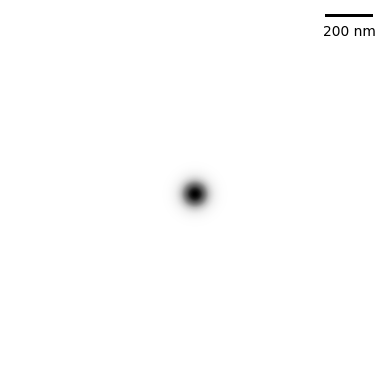

In [14]:
zero_wavelength_PSF = np.array([[0,0,0],[0,1,0],[0,0,0]])
pad_amount = 400

radius = 200
wavelength = 0.65
NA = 1.45
n = 1.518
resize_amount = 1
pix_mic_conv = 0.065 / 17
apo_sigma = 11

PC_PSF = PSF_generator(
    radius = radius,
    wavelength = wavelength,
    NA = NA,
    n = n,
    resize_amount = resize_amount,
    pix_mic_conv = pix_mic_conv,
    apo_sigma = apo_sigma,
    mode="phase contrast",
    condenser = "Ph3",
    offset=0.00000000225
)
PC_PSF.calculate_PSF()
PC_PSF.plot_PSF()

In [15]:
cell_length = (3,)
grid_size = 30
max_width = 3.1
cell_width = np.linspace(0.5, max_width, grid_size)
slice_amounts = np.arange(0, 3, np.diff(cell_width)[0]).tolist() 
slice_amounts = slice_amounts + [0]
tolerance = 0.1
param_space = []
widths = []
ID = 0
for length in cell_length:
    for width in cell_width:
        if length >= width:
            for slice_amount in slice_amounts:
                if slice_amount < width:
                    param_space.append([length, width, slice_amount, ID])
                    ID += 1
#param_space = param_space[:16]
print(len(param_space))


574


In [16]:
try:
    os.mkdir("A_B_single_cells_slice_projection_short_cells/")
except:
    pass

In [ ]:
_ = Parallel(n_jobs=-1)(delayed(generate_binary_cell)(length, width, slice_amount,  pad_amount, ID) for length, width, slice_amount, ID in tqdm(param_space))

  0%|          | 0/574 [00:00<?, ?it/s]

In [ ]:
_ = Parallel(n_jobs=-1)(delayed(generate_membrane_cell)(length, width, additional_width,  pad_amount, ID) for length, width, additional_width, ID in tqdm(param_space))

In [ ]:
timeout = 999999999
_ = Parallel(n_jobs=-1, timeout = timeout)(delayed(generate_FL_cell)(length, width, additional_width,  pad_amount, ID) for length, width, additional_width, ID in tqdm(param_space))

In [123]:
len(glob("A_B_single_cells_slice_projection/*binary*"))*5

3220

In [117]:
list(np.array(param_space)[[72, 73, 74, 75, 76, 77, 256, 262, 263, 264, 265, 266, 267]])

[array([ 6.        ,  1.12758621,  0.17931034, 72.        ]),
 array([ 6.        ,  1.12758621,  0.26896552, 73.        ]),
 array([ 6.        ,  1.12758621,  0.35862069, 74.        ]),
 array([ 6.        ,  1.12758621,  0.44827586, 75.        ]),
 array([ 6.        ,  1.12758621,  0.53793103, 76.        ]),
 array([ 6.        ,  1.12758621,  0.62758621, 77.        ]),
 array([6.00000000e+00, 2.02413793e+00, 8.96551724e-02, 2.56000000e+02]),
 array([  6.        ,   2.02413793,   0.62758621, 262.        ]),
 array([  6.        ,   2.02413793,   0.71724138, 263.        ]),
 array([  6.        ,   2.02413793,   0.80689655, 264.        ]),
 array([  6.        ,   2.02413793,   0.89655172, 265.        ]),
 array([  6.        ,   2.02413793,   0.9862069 , 266.        ]),
 array([  6.        ,   2.02413793,   1.07586207, 267.        ])]

In [149]:
idx = np.array((sorted([int(x.split("/")[-1].split("_")[0]) for x in glob("A_B_single_cells_slice_projection/*FL*")])))

In [150]:
for x in range(644):
    if np.sum(idx == x) != 5:
        print(x)

In [133]:
counter = 0
current_num = 0
for x in idx:
    
    should_be = current_num*5
    if counter < 5:
        current_num += x
        counter += 1
    else: 
        if current_num != should_be:
            print(x)
        counter = 0
        current_num = x+1

2
3
4
5
7
8
9
10
11
13
14
15
16
17
19
20
21
22
23
25
26
27
28
29
31
32
33
34
35
37
38
39
40
41
43
44
45
46
47
49
50
51
52
53
55
56
57
58
59
61
62
63
65
66
68
70
71
73
74
75
76
77
79
80
81
82
83
85
86
87
88
89
91
92
93
94
95
97
98
99
100
101
103
104
105
106
107
109
110
111
112
113
115
116
117
118
119
121
122
123
124
125
127
128
129
130
131
133
134
135
136
137
139
140
141
142
143
145
146
147
148
149
151
152
153
154
155
157
158
159
160
161
163
164
165
166
167
169
170
171
172
173
175
176
177
178
179
181
182
183
184
185
187
188
189
190
191
193
194
195
196
197
199
200
201
202
203
205
206
207
208
209
211
212
213
214
215
217
218
219
220
221
223
224
225
226
227
229
230
231
232
233
235
236
237
238
239
241
242
243
244
245
247
248
249
250
252
253
254
255
257
258
259
260
261
263
264
265
266
267
269
270
271
272
273
275
276
277
278
279
281
282
283
284
285
287
288
289
290
291
293
294
295
296
297
299
300
301
302
303
305
306
307
308
309
311
312
313
314
315
317
318
319
320
321
323
324
325
326
327
329
330

In [136]:
[item for item in range(idx[0], idx[-1]+1) if item not in np.unique(idx)]

[]

In [151]:
len(glob("A_B_single_cells_slice_projection/*FL*"))

3220